## Introduction

In this project, we scraped chocolate product data from [chocolate.co.uk](https://www.chocolate.co.uk), cleaned the data, and performed simple analysis using Python.

We followed 3 main steps:
- Scraping Data
- Cleaning Data
- Data Analysis

## Scraping Chocolate Product Data

### Step 1: Web Scraping

In [7]:
from bs4 import BeautifulSoup as bs4
import pandas as pd
import requests

def scrape_all_products(pages=3):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
    }

    all_products = []

    for page in range(1, pages + 1):
        url = f"https://www.chocolate.co.uk/collections/all?page={page}"

        try:
            send_request = requests.get(url, headers=headers)
            send_request.raise_for_status()
            soup = bs4(send_request.text, 'html.parser')
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch page {page}: {e}")
            continue

        chocolate_cards = soup.find_all('div', class_='product-item__info')
        print(f"Found {len(chocolate_cards)} products on page {page}")

        for card in chocolate_cards:
            title_div = card.find('div', class_='product-item-meta')
            title_tag = title_div.find('a') if title_div else None
            Name = title_tag.text.strip() if title_tag else "No Title"
            product_url = title_tag['href'] if title_tag else None

            price_tag = card.find('div', class_='product-item-meta__price-list-container')
            price_span = price_tag.find('span', class_='price') if price_tag else None
            price = price_span.text.strip() if price_span else "No Price"

            if product_url:
                product_page = requests.get(f'https://www.chocolate.co.uk{product_url}', headers=headers)
                product_soup = bs4(product_page.text, 'html.parser')
                ingredients = "No Ingredients"
                ingredients_div = product_soup.find('div', class_='metafield-rich_text_field')
                if ingredients_div:
                    for p in ingredients_div.find_all('p'):
                        if 'Ingredients:' in p.text:
                            ingredients = p.text.replace("Ingredients:", "").strip()
                            break
            else:
                ingredients = "No URL"

            full_url = f'https://www.chocolate.co.uk{product_url}'

            product = {
                "Name": Name,
                "Price": price,
                "Ingredients": ingredients,
                "URL": full_url
            }

            all_products.append(product)

    df = pd.DataFrame(all_products)
    print(f"\nScraped {len(df)} products in total.\n")
    print(df.head())
    return df

data = scrape_all_products(3)


Found 24 products on page 1
Found 24 products on page 2
Found 6 products on page 3

Scraped 54 products in total.

                                      Name                 Price  \
0  2.5kg Bulk 41% Milk Hot Chocolate Drops      Sale price£50.00   
1  2.5kg Bulk 61% Dark Hot Chocolate Drops      Sale price£50.00   
2             41% Milk Hot Chocolate Drops       Sale price£8.75   
3             61% Dark Hot Chocolate Drops       Sale price£8.75   
4                           Almost Perfect  Sale priceFrom £1.00   

                                         Ingredients  \
0  Milk Chocolate (41% Cocoa Minimum, Pure Cocoa ...   
1  Dark Chocolate (61% Cocoa Minimum, Pure Cocoa ...   
2  Milk Chocolate (41% Cocoa Minimum, Pure Cocoa ...   
3  Dark Chocolate (61% Cocoa Minimum, Pure Cocoa ...   
4                                     No Ingredients   

                                                 URL  
0  https://www.chocolate.co.uk/products/2-5kg-bul...  
1  https://www.chocolate.co.u

## Cleaning and Formatting the Data

### Step 2: Data Cleaning

In [21]:
# Check for missing values
data.isna().sum()
# Check for duplicate values
data.duplicated()

Name           0
Price          0
Ingredients    0
URL            0
dtype: int64

## Cleaning block

In [9]:
df = pd.read_csv(r"C:\Users\user\Downloads\Chocolate_Products\New_chocolate_product_dataset.csv")

df['Price'] = df['Price'].str.replace('Sale price', '', regex=False)
df['Price'] = df['Price'].str.replace('From', '', regex=False)
df['Price'] = df['Price'].str.strip()
df['Price (€)'] = df['Price'].str.replace(r'[^\d.]', '', regex=True).astype(float).astype(int)
df['Name'] = df['Name'].str.title()
df

## currency conversion

In [10]:
exchange_rate = 1.1424
df['Price ($)'] = (df['Price (€)'] * exchange_rate).round(6)
df['Price ($)'] = df['Price ($)'].map(lambda x: ('%.4f' % x).rstrip('0').rstrip('.'))

# Drop old column
del df['Price']

## Column reordering

In [11]:
cols = list(df.columns)
cols.remove('Ingredients')
cols.append('Ingredients')
cols.remove('URL')
cols.append('URL')
df = df[cols]

## Final Cleaned Data

In [12]:
df1 = df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},  
    {'selector': 'td', 'props': [('text-align', 'center')]},
]).set_properties(
    subset=['Name'],
    **{'text-align': 'right'}
)

,Name,Price (€),Price ($),Ingredients,URL
0,2.5Kg Bulk 41% Milk Hot Chocolate Drops,50,57.12,"Milk Chocolate (41% Cocoa Minimum, Pure Cocoa Butter, 19% Milk Solids) (100%): Sugar, Cocoa Butter, Milk Powder, Cocoa Beans, Emulsifier: Soya Lecithin, Vanilla Extract.",https://www.chocolate.co.uk/products/2-5kg-bulk-of-our-41-milk-hot-chocolate-drops
1,2.5Kg Bulk 61% Dark Hot Chocolate Drops,50,57.12,"Dark Chocolate (61% Cocoa Minimum, Pure Cocoa Butter) (100%): Cocoa Beans, Sugar, Cocoa Butter, Emulsifier: Soya Lecithin, Vanilla Extract.",https://www.chocolate.co.uk/products/2-5kg-of-our-best-selling-61-dark-hot-chocolate-drops
2,41% Milk Hot Chocolate Drops,8,9.1392,"Milk Chocolate (41% Cocoa Minimum, Pure Cocoa Butter, 19% Milk Solids) (100%): Sugar, Cocoa Butter, Milk Powder, Cocoa Beans, Emulsifier: Soya Lecithin, Vanilla Extract.",https://www.chocolate.co.uk/products/41-colombian-milk-hot-chocolate-drops
3,61% Dark Hot Chocolate Drops,8,9.1392,"Dark Chocolate (61% Cocoa Minimum, Pure Cocoa Butter) (100%): Cocoa Beans, Sugar, Cocoa Butter, Emulsifier: Soya Lecithin, Vanilla Extract.",https://www.chocolate.co.uk/products/62-dark-hot-chocolate
4,Almost Perfect,1,1.1424,No Ingredients,https://www.chocolate.co.uk/products/almost-perfect
5,Assorted Chocolate Malt Balls,9,10.2816,"White Chocolate (25%) (32% Cocoa Minimum, Pure Cocoa Butter) (65%): Cocoa Butter, Sugar, Whole Milk Powder, Skimmed Milk Powder, Whey Powder, Caramelised Sugar, Emulsifier: (Soya Lecithin), Natural Vanilla Flavouring, Salt. Milk Chocolate (41% Cocoa Minimum, Pure Cocoa Butter, 19% Milk Solids): Sugar, Cocoa Butter, Milk Powder, Cocoa Beans, Emulsifier: Sunflower Lecithin, Natural Vanilla Extract. Dark Chocolate (25%) (61% Cocoa Minimum, Pure Cocoa Butter): Cocoa Beans, Sugar, Cocoa Butter, Emulsifier: Sunflower Lecithin, Natural Vanilla Extract. Malt Ball Centres (25%): Corn Syrup, Sugar, Dairy Blend (Whey, Whey Protein Concentrate), Malt Powder (Malted Barley, Wheat, Milk, Hydrolyzed Wheat Gluten, Sodium Bicarbonate, Salt), Malted Barley, Soya Lecithin, Salt. Gum Arabic.",https://www.chocolate.co.uk/products/assorted-chocolate-malt-balls
6,Blonde Caramel,5,5.712,"White Chocolate (35% Cocoa Minimum, Pure Cocoa Butter): Cocoa Butter, Sugar, Whole Milk Powder, Skimmed Milk Powder, Whey Powder, Butter, Emulsifier: (Soya Lecithin), Natural Vanilla Flavouring.",https://www.chocolate.co.uk/products/blonde-caramel-chocolate-bar
7,Blonde Chocolate Honeycomb - Bag,8,9.1392,"White Chocolate (Min 35% Cocoa Min, Pure Cocoa Butter, 24.7% Milk Solids): Cocoa Butter, Sugar, Whole Milk Powder, Dried Skimmed Milk, Whey, Butter, Emulsifier: (Soya Lecithin), Natural Vanilla Extract, Honeycomb (Sugar, Glucose Syrup, Bicarbonate of Soda, Honey).",https://www.chocolate.co.uk/products/blonde-chocolate-sea-salt-honeycomb
8,Blonde Chocolate Malt Balls,9,10.2816,"White Chocolate (32% Cocoa Minimum, Pure Cocoa Butter) (65%): Cocoa Butter, Sugar, Whole Milk Powder, Skimmed Milk Powder, Whey Powder, Caramelised Sugar, Emulsifier: (Soya Lecithin), Natural Vanilla Flavouring, Salt. Malt Ball Centres (35%): Corn Syrup, Sugar, Dairy Blend (Whey, Whey Protein Concentrate), Malt Powder (Malted Barley, Wheat, Milk, Hydrolyzed Wheat Gluten, Sodium Bicarbonate, Salt), Malted Barley, Soya Lecithin, Salt.",https://www.chocolate.co.uk/products/blonde-chocolate-malt-balls
9,Blonde Chocolate Truffles,19,21.7056,"White Chocolate (32% Cocoa Minimum, Pure Cocoa Butter, 24.7% Milk Solid) Sugar, Cocoa Butter, Whole Milk Powder, Dried Skimmed Milk, Whey, Butter, Emulsifier (Soya Lecithin), Natural Vanilla Extract, Cream, Glucose, Sorbitol, Sunflower Lecithin.",https://www.chocolate.co.uk/products/blonde-chocolate-truffles


## Products were scraped

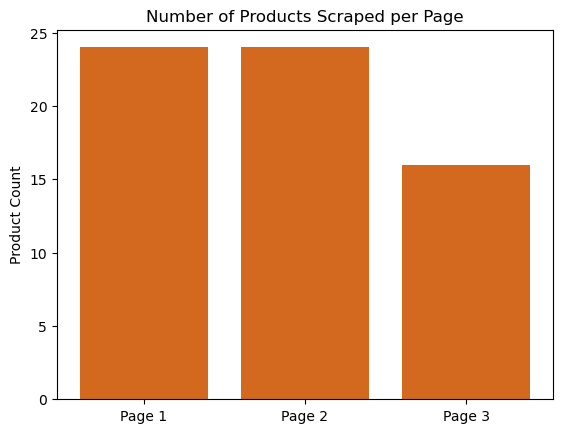

In [29]:
import matplotlib.pyplot as plt
page_counts = [24, 24, 16]
plt.bar(['Page 1', 'Page 2', 'Page 3'], page_counts, color='chocolate')
plt.title("Number of Products Scraped per Page")
plt.ylabel("Product Count")
plt.show()

## Visualizing Price Distribution

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


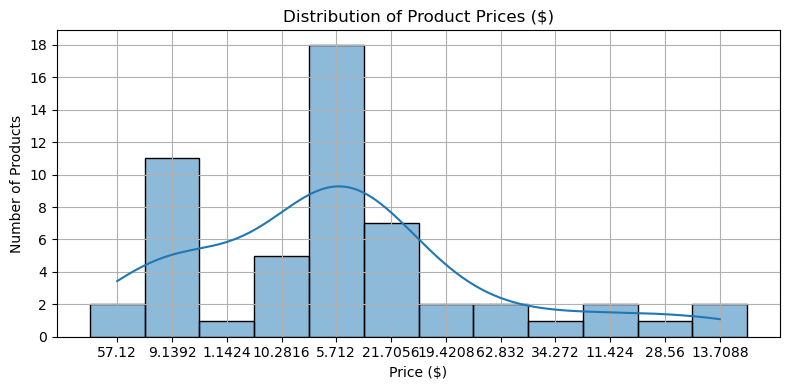

In [30]:
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(8, 4))
sns.histplot(df['Price ($)'], bins=10, kde=True)
plt.title('Distribution of Product Prices ($)')
plt.xlabel('Price ($)')
plt.ylabel('Number of Products')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.tight_layout()
plt.show()

## Missing Ingredients

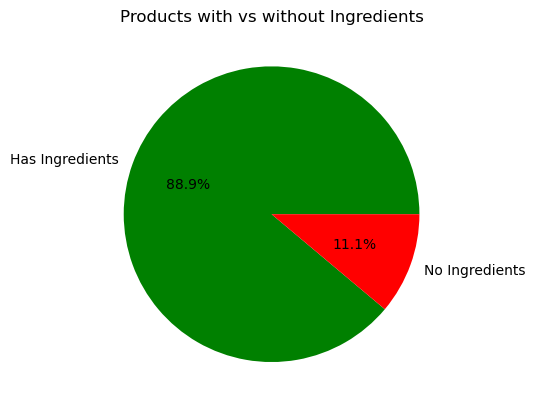

In [15]:
has_ingredients = df['Ingredients'].apply(lambda x: x != 'No Ingredients').sum()
no_ingredients = len(df) - has_ingredients

plt.pie([has_ingredients, no_ingredients],
        labels=['Has Ingredients', 'No Ingredients'],
        colors=['green', 'red'],
        autopct='%1.1f%%')
plt.title("Products with vs without Ingredients")
plt.show()

## Top 10 Expensive Chocolates

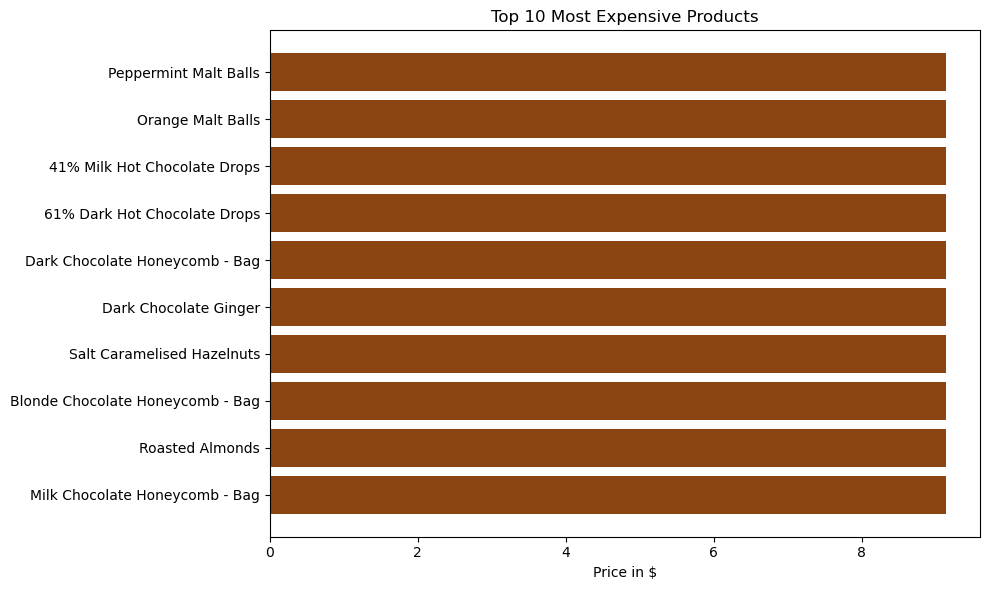

In [31]:
top_prices = df.sort_values(by='Price ($)', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_prices['Name'], top_prices['Price ($)'].astype(float), color='saddlebrown')
plt.xlabel('Price in $')
plt.title('Top 10 Most Expensive Products')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# THANK YOU !!!